In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.metrics import precision_recall_curve


### Reading CSV file

In [2]:
train = pd.read_csv("train.csv")
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [89]:
train_eda = train.sample(frac = 0.2)
train_eda.shape

(261224, 3)

### Plotting Pie chart for data imbalance

In [90]:
train_0 = (train['target'] == 1)
train_1_1= sum(train_0 == True)
train_1_0= sum(train_0 == False)

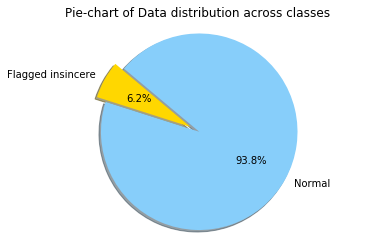

In [91]:
labels = 'Flagged insincere', 'Normal'
sizes = [train_1_1, train_1_0]
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pie-chart of Data distribution across classes')
plt.axis('equal')
plt.show()

### Wordcloud

In [93]:
all_questions = " ".join(x for x in train.question_text)

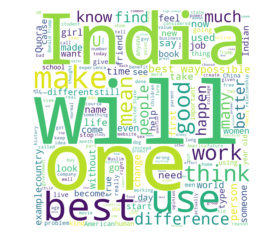

In [94]:
stopwords = set(STOPWORDS) 
cloud_1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_questions)

plt.imshow(cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#offensive data wordcloud
train_offensive = train.loc[train['target'] == 1]

In [ ]:
all_questions_offensive = " ".join(x for x in train_offensive.question_text)

In [ ]:
train_offensive = pd.DataFrame(train_offensive)
all_questions_offensive = " ".join(x for x in train_offensive.question_text)
stopwords = set(STOPWORDS) 
cloud_offensive = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_questions_offensive)

plt.imshow(cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vectorizing

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train, test_size=0.10, random_state=42)

In [ ]:
train_df.shape #(1175509, 3)
test_df.shape       #(130613, 3)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char',stop_words= 'english',ngram_range=(1,6),dtype=np.float32)


In [5]:
train_original = train_df
test_original = test_df
train_df = train_original.sample(frac = 0.5)
test_df = test_original.sample(frac = 0.5)

In [6]:
#vect_word.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect = vect_word.fit_transform(train_df['question_text'])
ts_vect = vect_word.transform(test_df['question_text'])

#vect_char.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect_char = vect_char.fit_transform(train_df['question_text'])
ts_vect_char = vect_char.transform(test_df['question_text'])


In [10]:
y = train_df['target']

In [9]:
from scipy import sparse
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])


In [35]:
y_test = test_df['target']

### Classifier: Logistic Regression 

In [ ]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

In [68]:
#pred = np.zeros((x_test.shape[0],y.shape[0]))
cv_score =[]
model = LogisticRegression()
model.fit(tr_vect,y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
prd = model.predict_proba(ts_vect)[:,1]
y_score = model.decision_function(ts_vect)

In [64]:
#confusion matrix for test dataset 
pred =  model.predict(ts_vect)
print('\nConfusion matrix\n',confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))


('\nConfusion matrix\n', array([[60678,   661],
       [ 2534,  1434]]))
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     61339
           1       0.68      0.36      0.47      3968

   micro avg       0.95      0.95      0.95     65307
   macro avg       0.82      0.68      0.72     65307
weighted avg       0.94      0.95      0.94     65307



The reported averages include:
1. micro average (averaging the total true positives, false negatives and false positives), 
2. macro average (averaging the unweighted mean per label), 
3. weighted average (averaging the support-weighted mean per label) and 


Note: in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

#### Hence, Sensitivity = 0.36, specificity = 0.99

#### Hence, Sensitivity = 0.36, specificity = 0.99

In [84]:
x_test = ts_vect
y_score = model.decision_function(x_test)

In [86]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.57


Text(0.5,1,'Precision Recall Curve: Avg precision-recall score=0.57')

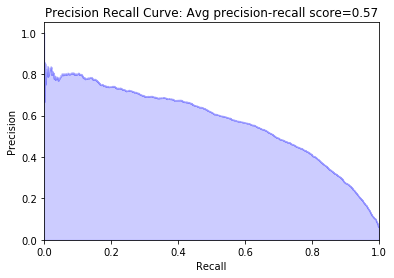

In [88]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve: Avg precision-recall score={0:0.2f}'.format(average_precision))